In [2]:
import numpy as np
import matplotlib.pyplot as plt

# "Particle" Class
A class which describes the properties of a particle.

In [8]:
class Particle():
    """
    x_pos = Position of Particle on x-axis.
    y_pos = Position of Particle on y-axis.
    vx = X-component of Velocity.
    vy = Y-component of Velocity.
    ax = X-component of Acceleration
    ay = Y-component of Acceleration
    colour = Colour of the particle
    """
    def __init__(self, x_pos, y_pos, colour, vx=0, vy=0, ax=0, ay=0):

        self.x = x_pos
        self.y = y_pos
        self.vx = vx
        self.vy = vy
        self.ax = ax
        self.ay = ay
        self.colour = colour

# "Create" class
A class to create multiple particles and assign random positions

In [61]:
class Create():
    """
        A class used to create particles with a particular colour.
        For example: 
                    green = Create(100, 'green')
        This will create 100 green coloured particles with random positions
                    
        Attributes:
        num = number of particles
        colour = colour of particles (e.g. 'green') (**string format**)
        x_limit = Range of x. (e.g. x_limit = 100 implies a range from 0 to 100 on x-axis)
        y_limit = Range of y. (e.g. y_limit = 220 implies a range from - to 220 on y-axis)
        """
    def __init__(self, num, colour, x_limit, y_limit):
        # size is the number of particle present.
        self.size = num
        self.colour = colour
        self.x_limit = x_limit
        self.y_limit = y_limit
        self.particle_list = self.create()
        
        # x and y component of positions of all particles
        self.x = [p.x for p in self.particle_list]
        self.y = [p.y for p in self.particle_list]
        
        # x and y velocity component of all particles
        self.vx = [p.vx for p in self.particle_list]
        self.vy = [p.vy for p in self.particle_list]
        
        # x and y acceleration component of all particles
        self.ax = [p.ax for p in self.particle_list]
        self.ay = [p.ay for p in self.particle_list]
        
    def create(self):
        # Creating an empty list to store particles.
        particle_list = []

        # Running a loop to generate particles:
        for i in range(self.size):
            # random x (integer between '0 to x_limit')
            ran_x = np.random.randint(0, self.x_limit)
            # random y (integer between '0 to y_limit')
            ran_y = np.random.randint(0, self.y_limit)
            
            # Creating a particle
            particle = Particle(x_pos=ran_x, y_pos=ran_y,colour=self.colour)
            
            # Addiing the particle in the list.
            particle_list.append(particle)
        # Returning the list
        
        #**Note: Particle velocity and acceleration are not updated and =0**
        return particle_list
    def update(self, x,y,vx,vy,ax,ay):
        """
        Updates the position, velocity and acceleration of all particles."""
        pass
    def plot(self, ax= None):
        """
        Plots the particles"""
        x_list, y_list, col = self.x, self.y, self.colour
        
        if ax is None:
            plt.scatter(x_list, y_list,c=col)
        else:
            ax.scatter(x_list, y_list,c=col)

In [67]:
green = Create(100, 'green', x_limit=100, y_limit=100)
red = Create(200,'red',x_limit=100,y_limit=200)

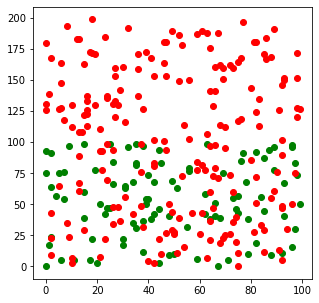

In [71]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
green.plot(ax)
red.plot(ax)
plt.show()

In [ ]:
class Rule():
    def __init_(self, particle1, particle2, force):
        """
        enter something later"""
        def __init__(self)